In [44]:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random



random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)


In [22]:

###############################################################################
# Download & load raw data
###############################################################################

def download_movielens_100k(dest_path='ml-100k.zip'):
    url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
    if not os.path.exists(dest_path):
        print("Downloading MovieLens 100k dataset...")
        r = requests.get(url, stream=True)
        with open(dest_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print("Download completed.")
    else:
        print("MovieLens 100k zip already exists. Skipping download.")

def extract_movielens_100k(zip_path='ml-100k.zip', extract_to='.'):
    ml_folder = os.path.join(extract_to, 'ml-100k')
    if not os.path.exists(ml_folder):
        print("Extracting ml-100k.zip...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Extraction completed.")
    else:
        print("ml-100k folder already exists. Skipping extraction.")

def load_ratings(path='ml-100k/u.data'):
    df = pd.read_csv(
        path,
        sep='\t',
        names=["user_id", "item_id", "rating", "timestamp"],
        engine='python'
    )
    return df

def load_users(path='ml-100k/u.user'):
    user_cols = ["user_id", "age", "gender", "occupation", "zip_code"]
    df_users = pd.read_csv(
        path,
        sep='|',
        names=user_cols,
        engine='python'
    )
    return df_users

def load_items(path='ml-100k/u.item'):
    item_cols = [
        "item_id",
        "movie_title",
        "release_date",
        "video_release_date",
        "imdb_url",
        "unknown",
        "Action",
        "Adventure",
        "Animation",
        "Children's",
        "Comedy",
        "Crime",
        "Documentary",
        "Drama",
        "Fantasy",
        "Film-Noir",
        "Horror",
        "Musical",
        "Mystery",
        "Romance",
        "Sci-Fi",
        "Thriller",
        "War",
        "Western"
    ]
    df_items = pd.read_csv(
        path,
        sep='|',
        names=item_cols,
        encoding='latin-1',
        engine='python'
    )
    return df_items

def split_data(df, train_frac=0.8, calib_frac=0.1, test_frac=0.1, seed=42):
    df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    n = len(df_shuffled)
    train_end = int(train_frac * n)
    calib_end = int((train_frac + calib_frac) * n)

    train_df = df_shuffled.iloc[:train_end]
    calib_df = df_shuffled.iloc[train_end:calib_end]
    test_df = df_shuffled.iloc[calib_end:]
    return train_df, calib_df, test_df

###############################################################################
# Preprocessing (including user/item ID reindexing & classification target)
###############################################################################

def preprocess_data_classification(merged_df):
    """
    1. Convert rating in [1..5] => class index [0..4].
    2. Re-index user_id and item_id => [0..num_users-1], [0..num_items-1].
    3. Encode gender => {M:0, F:1}, encode occupation & zip_code.
    4. Extract release_year from release_date.
    5. Return a DataFrame with numeric columns and these new IDs.
    """
    df = merged_df.copy()

    # 1) rating => [0..4]
    df['rating_class'] = df['rating'] - 1  # rating 1 => class 0, rating 5 => class 4

    # 2) re-index user_id
    unique_users = df['user_id'].unique()
    user2idx = {u: i for i, u in enumerate(unique_users)}
    df['user_id_idx'] = df['user_id'].map(user2idx)

    # re-index item_id
    unique_items = df['item_id'].unique()
    item2idx = {i: j for j, i in enumerate(unique_items)}
    df['item_id_idx'] = df['item_id'].map(item2idx)

    # 3) encode gender => {M:0, F:1}
    df['gender'] = df['gender'].map({'M': 0, 'F': 1}).fillna(0).astype(int)

    # encode occupation
    occ_unique = df['occupation'].unique().tolist()
    occ_to_idx = {o: i for i, o in enumerate(occ_unique)}
    df['occupation'] = df['occupation'].map(occ_to_idx).fillna(0).astype(int)

    # encode zip_code similarly
    zip_unique = df['zip_code'].unique().tolist()
    zip_to_idx = {z: i for i, z in enumerate(zip_unique)}
    df['zip_code'] = df['zip_code'].map(zip_to_idx).fillna(0).astype(int)

    # 4) parse release_year
    def extract_year(date_str):
        if pd.isna(date_str):
            return 0
        parts = date_str.split('-')
        if len(parts) == 3:
            try:
                return int(parts[2])  # e.g. "01-Jan-1994" => 1994
            except:
                return 0
        else:
            return 0
    df['release_year'] = df['release_date'].apply(extract_year)

    # drop unused columns
    df.drop(columns=['movie_title', 'release_date', 'video_release_date',
                     'imdb_url'], inplace=True)

    return df, user2idx, item2idx

###############################################################################
# PyTorch Dataset for classification
###############################################################################

class MovieLensClassifDataset(Dataset):
    def __init__(self, df):
        super().__init__()

        # We'll store user_id_idx, item_id_idx as separate columns for embeddings
        self.user_ids = torch.tensor(df['user_id_idx'].values, dtype=torch.long)
        self.item_ids = torch.tensor(df['item_id_idx'].values, dtype=torch.long)

        # rating_class is [0..4]
        self.y = torch.tensor(df['rating_class'].values, dtype=torch.long)

        # Prepare side features: age, gender, occupation, zip_code, timestamp, release_year, plus genre flags, etc.
        # We'll decide which columns to treat as side features:
        side_cols = [
            'age', 'gender', 'occupation', 'zip_code', 'timestamp', 'release_year',
            'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
            'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
            'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
        ]

        # Make sure those columns exist in df
        for col in side_cols:
            if col not in df.columns:
                df[col] = 0  # or handle differently if missing

        self.side_info = torch.tensor(df[side_cols].values, dtype=torch.float32)
        self.side_cols = side_cols

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return (self.user_ids[idx],
                self.item_ids[idx],
                self.side_info[idx]), self.y[idx]

###############################################################################
# Model: Embedding for user/item + MLP on side info => combine => final 5 logits
###############################################################################

class DeepRecommenderClassifier(nn.Module):
    def __init__(self,
                 num_users,
                 num_items,
                 user_emb_dim=20,
                 item_emb_dim=20,
                 side_in_dim=26,  # depends on how many side columns
                 side_hidden=32,
                 final_hidden=32,
                 num_classes=5,
                 dropout_rate=0.3):
        """
        num_users, num_items: for embeddings
        user_emb_dim, item_emb_dim: embedding sizes
        side_in_dim: dimension of side_info
        side_hidden: hidden dim for side MLP
        final_hidden: hidden dim after combining
        num_classes: we have 5 rating classes (0..4)
        dropout_rate: dropout probability
        """
        super().__init__()

        # Embeddings
        self.user_emb = nn.Embedding(num_users, user_emb_dim)
        self.item_emb = nn.Embedding(num_items, item_emb_dim)

        # MLP for side info with BatchNorm and Dropout
        self.side_mlp = nn.Sequential(
            nn.Linear(side_in_dim, side_hidden),
            nn.BatchNorm1d(side_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(side_hidden, side_hidden),
            nn.BatchNorm1d(side_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Final combination
        comb_in_dim = user_emb_dim + item_emb_dim + side_hidden

        self.final_mlp = nn.Sequential(
            nn.Linear(comb_in_dim, final_hidden),
            nn.BatchNorm1d(final_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(final_hidden, num_classes)
        )

    def forward(self, user_ids, item_ids, side_info):
        # Look up embeddings
        ue = self.user_emb(user_ids)   # (batch, user_emb_dim)
        ie = self.item_emb(item_ids)   # (batch, item_emb_dim)

        # MLP on side info
        se = self.side_mlp(side_info)  # (batch, side_hidden)

        # Combine
        x = torch.cat([ue, ie, se], dim=1)  # (batch, user_dim + item_dim + side_hidden)
        logits = self.final_mlp(x)          # (batch, 5)
        return logits

###############################################################################
# Training + accuracy
###############################################################################

def train_one_epoch_classif(model, loader, optimizer, device='cpu'):
    model.train()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_samples = 0

    for (user_ids, item_ids, side_info), y_class in loader:
        user_ids = user_ids.to(device)
        item_ids = item_ids.to(device)
        side_info = side_info.to(device)
        y_class = y_class.to(device)

        optimizer.zero_grad()
        logits = model(user_ids, item_ids, side_info)
        loss = criterion(logits, y_class)
        loss.backward()
        optimizer.step()

        batch_size = y_class.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    return avg_loss

def evaluate_classif(model, loader, device='cpu'):
    """
    Returns average cross-entropy and accuracy (exact match).
    """
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='sum')  # sum to do total
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for (user_ids, item_ids, side_info), y_class in loader:
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            side_info = side_info.to(device)
            y_class = y_class.to(device)

            logits = model(user_ids, item_ids, side_info)
            loss = criterion(logits, y_class)

            # Accuracy
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == y_class).sum().item()

            total_samples += y_class.size(0)
            total_loss += loss.item()

    avg_loss = total_loss / total_samples
    accuracy = 100.0 * total_correct / total_samples
    return avg_loss, accuracy


In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# 1. Download & extract
download_movielens_100k("ml-100k.zip")
extract_movielens_100k("ml-100k.zip", ".")

# 2. Load data
ratings_df = load_ratings("ml-100k/u.data")
users_df   = load_users("ml-100k/u.user")
items_df   = load_items("ml-100k/u.item")

# 3. Merge
merged_df = pd.merge(ratings_df, users_df, on="user_id", how="left")
merged_df = pd.merge(merged_df, items_df, on="item_id", how="left")

# 4. Preprocess for classification
df_classif, user2idx, item2idx = preprocess_data_classification(merged_df)

# 5. Split
train_df, calib_df, test_df = split_data(df_classif, 0.8, 0.1, 0.1, seed=42)
print(f"Train: {train_df.shape}, Calib: {calib_df.shape}, Test: {test_df.shape}")

# 6. Datasets & Loaders
train_data = MovieLensClassifDataset(train_df)
calib_data = MovieLensClassifDataset(calib_df)
test_data  = MovieLensClassifDataset(test_df)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
calib_loader = DataLoader(calib_data, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=256, shuffle=False)

# 7. Model
num_users = len(user2idx)
num_items = len(item2idx)
# side_in_dim = number of features in side_info (determined by dataset).
# Let's see:
side_in_dim = train_data.side_info.shape[1]
print("Side info dimension:", side_in_dim)

model = DeepRecommenderClassifier(
    num_users=num_users,
    num_items=num_items,
    user_emb_dim=32,
    item_emb_dim=32,
    side_in_dim=side_in_dim,
    side_hidden=64,
    final_hidden=64,
    num_classes=5
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 8. Training loop
epochs = 20
for epoch in range(1, epochs+1):
    train_loss = train_one_epoch_classif(model, train_loader, optimizer, device)
    val_loss, val_acc = evaluate_classif(model, calib_loader, device)
    print(f"Epoch {epoch}/{epochs}: Train Loss={train_loss:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

# 9. Final test evaluation
test_loss, test_acc = evaluate_classif(model, test_loader, device)
print(f"\nFinal Test Loss={test_loss:.4f}, Test Accuracy={test_acc:.2f}%")


Using device: cpu
MovieLens 100k zip already exists. Skipping download.
ml-100k folder already exists. Skipping extraction.
Train: (80000, 31), Calib: (10000, 31), Test: (10000, 31)
Side info dimension: 25
Epoch 1/20: Train Loss=1.4750, Val Loss=1.7119, Val Acc=34.79%
Epoch 2/20: Train Loss=1.4214, Val Loss=1.4569, Val Acc=34.79%
Epoch 3/20: Train Loss=1.3785, Val Loss=1.3668, Val Acc=38.44%
Epoch 4/20: Train Loss=1.3392, Val Loss=1.3235, Val Acc=40.58%
Epoch 5/20: Train Loss=1.3097, Val Loss=1.2994, Val Acc=42.20%
Epoch 6/20: Train Loss=1.2879, Val Loss=1.2888, Val Acc=42.73%
Epoch 7/20: Train Loss=1.2719, Val Loss=1.2762, Val Acc=43.06%
Epoch 8/20: Train Loss=1.2573, Val Loss=1.2730, Val Acc=43.64%
Epoch 9/20: Train Loss=1.2482, Val Loss=1.2705, Val Acc=43.67%
Epoch 10/20: Train Loss=1.2393, Val Loss=1.3014, Val Acc=43.32%
Epoch 11/20: Train Loss=1.2322, Val Loss=1.2685, Val Acc=43.86%
Epoch 12/20: Train Loss=1.2255, Val Loss=1.2864, Val Acc=43.33%
Epoch 13/20: Train Loss=1.2210, Val

**Implementation of the best response baseline.:**

In [45]:
import torch
import numpy as np

def evaluate_baseline_best_response(model, test_loader, alpha, device='cpu'):
    """
    Baseline: for each sample, pick the action (recommend/not recommend) that
    maximizes the *expected utility* given the model's predicted probabilities.

    Utility function (as in original code):
      - If a=0 (not recommend), u=0.
      - If a=1 (recommend), u = (rating in [1..5]) - 3.

    Reports:
      - Average utility
      - Percentage recommended by true rating
      - Utility histogram (empirical PDF)
      - alpha-quantile of realized utilities
    """
    model.eval()
    model.to(device)

    # Keep track of total utility and sample count
    total_utility = 0.0
    total_samples = 0
    utility_values = []

    # rating_counts[r], recommend_counts[r] for r in [1..5]
    rating_counts = {r: 0 for r in [1, 2, 3, 4, 5]}
    recommend_counts = {r: 0 for r in [1, 2, 3, 4, 5]}

    # Utility histogram for possible realized utilities in {-2, -1, 0, 1, 2}
    # (since u=0 if not recommend, or u=(r-3) if recommend)
    utility_histogram = {u: 0 for u in [-2, -1, 0, 1, 2]}

    with torch.no_grad():
        for batch in test_loader:
            (user_ids, item_ids, side_info), y_true_class = batch
            user_ids   = user_ids.to(device)
            item_ids   = item_ids.to(device)
            side_info  = side_info.to(device)
            y_true_class = y_true_class.to(device)  # rating in [0..4], so "true rating" = y_true_class+1 in [1..5]

            # Forward pass -> logits -> convert to probabilities
            logits = model(user_ids, item_ids, side_info)  # shape (batch_size, 5)
            probs  = torch.softmax(logits, dim=1)          # shape (batch_size, 5)

            batch_size = y_true_class.shape[0]

            for i in range(batch_size):
                # True rating is in [1..5]
                r_true = int(y_true_class[i].item()) + 1
                rating_counts[r_true] += 1
                total_samples += 1

                # Probability vector for the 5 possible ratings
                p_vec = probs[i]  # shape (5,)
                # We'll move it to CPU numpy for easier handling, if needed
                p_np = p_vec.detach().cpu().numpy()

                # For each action a in {0,1}, compute E[u(a)] = sum_{r=1..5} p[r-1]*u(a, r)
                # where u(0,r)=0 and u(1,r)=r-3
                # Let's define a small function for this local case:
                def exp_utility(a):
                    e_val = 0.0
                    for rating_idx in range(5):  # rating_idx=0..4 => r=rating_idx+1
                        r = rating_idx + 1
                        if a == 1:
                            # recommend => utility = r - 3
                            e_val += p_np[rating_idx] * (r - 3)
                        else:
                            # a=0 => no recommend => utility=0
                            e_val += p_np[rating_idx] * 0.0
                    return e_val

                # Decide best action
                exp_u_0 = exp_utility(a=0)
                exp_u_1 = exp_utility(a=1)
                if exp_u_1 > exp_u_0:
                    final_action = 1  # recommend
                else:
                    final_action = 0  # not recommend

                # Realized utility with the true rating r_true
                if final_action == 1:
                    # recommend => utility = r_true - 3
                    u_val = r_true - 3
                    recommend_counts[r_true] += 1
                else:
                    # not recommend => utility = 0
                    u_val = 0

                total_utility += u_val
                utility_values.append(u_val)

                # Update utility histogram if it's in [-2, -1, 0, 1, 2]
                if u_val in utility_histogram:
                    utility_histogram[u_val] += 1

    # Averages
    avg_utility = total_utility / total_samples if total_samples > 0 else 0.0

    # Percentage recommended by true rating
    recommend_percents = {}
    for r in [1, 2, 3, 4, 5]:
        if rating_counts[r] > 0:
            perc = 100.0 * recommend_counts[r] / rating_counts[r]
        else:
            perc = 0.0
        recommend_percents[r] = perc

    # Convert histogram to PDF
    total_util_count = sum(utility_histogram.values())
    utility_pdf = {}
    for u_val, count in utility_histogram.items():
        if total_util_count > 0:
            utility_pdf[u_val] = count / total_util_count
        else:
            utility_pdf[u_val] = 0.0

    # alpha-Quantile of realized utilities
    sorted_utils = sorted(utility_values)
    alpha_quantile = float(np.quantile(sorted_utils, alpha)) if len(sorted_utils) > 0 else 0.0

    print("=== Baseline: Best Response (Expected Utility) ===")
    print(f"Average Utility = {avg_utility:.4f}")
    for r in [1, 2, 3, 4, 5]:
        print(f"  True rating {r}: recommended {recommend_percents[r]:.2f}% of the time")

    print("Utility Histogram (Empirical PDF):")
    for u_val in sorted(utility_pdf.keys()):
        print(f"  Utility {u_val}: {utility_pdf[u_val]:.4f}")

    print(f"Alpha-Quantile ({alpha*100:.1f}%): {alpha_quantile:.4f}")

    return avg_utility, recommend_percents, utility_pdf, alpha_quantile


An example.

In [46]:
avg_utility, recommend_stats, utility_pdf, _ = evaluate_baseline_best_response(model, test_loader, 0.1, device=device)
print(utility_pdf)

=== Baseline: Best Response (Expected Utility) ===
Average Utility = 0.6015
  True rating 1: recommended 40.97% of the time
  True rating 2: recommended 60.77% of the time
  True rating 3: recommended 79.18% of the time
  True rating 4: recommended 93.83% of the time
  True rating 5: recommended 97.49% of the time
Utility Histogram (Empirical PDF):
  Utility -2: 0.0263
  Utility -1: 0.0725
  Utility 0: 0.3767
  Utility 1: 0.3224
  Utility 2: 0.2021
Alpha-Quantile (10.0%): 0.0000
{-2: 0.0263, -1: 0.0725, 0: 0.3767, 1: 0.3224, 2: 0.2021}


**Implementation of score-1**

In [48]:
import torch
import numpy as np

###############################################################################
# 1) Compute the conformal threshold T on the calibration set
###############################################################################

def compute_conformal_threshold(model, calib_loader, alpha=0.2, device='cpu'):
    """
    - model: classification model with logits of shape (batch_size, 5)
    - calib_loader: DataLoader for the calibration set
    - alpha=0.2 => coverage ~80%
    Returns: threshold T
    """
    model.eval()
    model.to(device)

    nonconformity_scores = []

    with torch.no_grad():
        for batch in calib_loader:
            # batch => ([user_ids, item_ids, side_info], y_class)
            #   y_class in {0..4}
            (user_ids, item_ids, side_info), y_class = batch

            user_ids  = user_ids.to(device)
            item_ids  = item_ids.to(device)
            side_info = side_info.to(device)
            y_class   = y_class.to(device)

            # Forward => logits => softmax => probabilities
            logits = model(user_ids, item_ids, side_info)  # (batch_size, 5)
            probs = torch.softmax(logits, dim=1)           # shape (batch_size,5)

            # For each i in batch, nonconformity = 1 - p_{y_i}(x_i)
            # y_class[i] is an integer 0..4
            for i in range(len(y_class)):
                true_c = y_class[i].item()        # 0..4
                p_true = probs[i, true_c].item()  # predicted probability for the correct class
                score = 1.0 - p_true
                nonconformity_scores.append(score)

    # Convert to numpy
    nonconformity_scores = np.array(nonconformity_scores)

    # Compute the (1-alpha) quantile => T
    # e.g. np.quantile(nonconformity_scores, 1-alpha)
    # We'll use method='higher' to be conservative, or you can choose method='linear'.
    T = float(np.quantile(nonconformity_scores, 1 - alpha, method='higher'))

    return T

###############################################################################
# 2) Evaluate the risk-averse policy on test set
###############################################################################

import torch
import numpy as np
from collections import defaultdict, Counter

def evaluate_conformal_policy(
    model,
    test_loader,
    T,
    u,
    alpha,
    device='cpu'
):
    """
    - model: classification model
    - test_loader: DataLoader for test set
    - T: threshold from conformal calibration
    - u: utility function: u(action, c) -> real
    - alpha: quantile value for utility histogram
    - device: 'cpu' or 'cuda'

    Policy (unchanged):
      1) For each sample, form S_indices = { c': p[c'] >= 1 - T }.
      2) If {0..2} intersect S_indices, utility = u(0, c) (not recommended),
         else utility = u(1, c) (recommended).

    Reports:
      - coverage: fraction of times c in S_indices
      - avg_utility
      - recommend_percents
      - utility_histogram & PDF
      - alpha-quantile
      - avg_maxmin (set to 0.0 here, for consistency with other baselines)
    """

    model.eval()
    model.to(device)

    total_utility = 0.0
    total_maxmin = 0.0
    total_samples = 0
    utility_values = []

    # Coverage counter
    coverage_count = 0

    # Track counts by true rating [1..5]
    rating_counts = {r: 0 for r in [1, 2, 3, 4, 5]}
    recommend_counts = {r: 0 for r in [1, 2, 3, 4, 5]}

    # We'll keep a histogram of possible utilities.
    # If you expect them only in [-2, -1, 0, 1, 2], you can keep that fixed.
    # Otherwise, let's use a Counter to track any realized utility.
    from collections import defaultdict
    utility_histogram = defaultdict(int)

    with torch.no_grad():
        for batch in test_loader:
            (user_ids, item_ids, side_info), y_class = batch
            user_ids  = user_ids.to(device)
            item_ids  = item_ids.to(device)
            side_info = side_info.to(device)
            y_class   = y_class.to(device)  # in [0..4]

            logits = model(user_ids, item_ids, side_info)
            probs = torch.softmax(logits, dim=1)  # shape: (batch_size, 5)
            batch_size = y_class.shape[0]

            for i in range(batch_size):
                c = int(y_class[i].item())  # true class in [0..4]
                r = c + 1  # true rating in [1..5]
                rating_counts[r] += 1
                total_samples += 1

                # Form S_indices
                p = probs[i]  # shape (5,)
                cutoff = 1.0 - T
                S_indices = (p >= cutoff).nonzero(as_tuple=True)[0].tolist()  # list of class indices

                # Coverage check
                if c in S_indices:
                    coverage_count += 1

                # Realized utility
                if any(x in [0,1,2] for x in S_indices):
                    # Not recommend
                    utility = u(0, c)
                    total_maxmin+=0
                elif 3 in S_indices:
                    # Recommend
                    utility = u(1, c)
                    recommend_counts[r] += 1
                    total_maxmin+=1
                else:
                    utility = u(1, c)
                    recommend_counts[r] += 1
                    total_maxmin+=2

                total_utility += utility
                utility_values.append(utility)
                utility_histogram[utility] += 1

    # 1) Coverage
    coverage = coverage_count / total_samples if total_samples > 0 else 0.0

    # 2) Average utility
    avg_utility = total_utility / total_samples if total_samples > 0 else 0.0
    avg_maxmin = total_maxmin / total_samples if total_samples > 0 else 0.0

    # 3) Recommendation percentages
    recommend_percents = {}
    for r in [1, 2, 3, 4, 5]:
        if rating_counts[r] > 0:
            recommend_percents[r] = 100.0 * recommend_counts[r] / rating_counts[r]
        else:
            recommend_percents[r] = 0.0

    # 4) Convert histogram to empirical PDF
    total_count = sum(utility_histogram.values())
    utility_pdf = {}
    for val, cnt in utility_histogram.items():
        if total_count > 0:
            utility_pdf[val] = cnt / total_count
        else:
            utility_pdf[val] = 0.0

    # 6) Print results
    print("=== Conformal Policy (risk-averse) ===")
    print(f"Threshold T = {T:.4f}, alpha={alpha}")
    print(f"Coverage: {coverage:.3f}")
    print(f"Average Utility: {avg_utility:.4f}\n")
    print("Recommend % by TRUE rating:")
    for r in [1, 2, 3, 4, 5]:
        print(f"  Rating={r}: recommended {recommend_percents[r]:.2f}%")

    print("\nUtility Histogram (Empirical Distribution):")
    for val in sorted(utility_pdf.keys()):
        print(f"  Utility {val}: {utility_pdf[val]:.4f}")
    # 7) Return a dictionary of results
    results_dict = {
        "coverage": coverage,
        "avg_utility": avg_utility,
        "recommend_percents": recommend_percents,
        "utility_histogram": dict(utility_histogram),
        "utility_pdf": utility_pdf,
        "avg_maxmin_value": avg_maxmin  # no max-min logic here, but included for consistency
    }

    return results_dict

###############################################################################
# USAGE EXAMPLE
###############################################################################

# You can run something like:
def example_utility_fn(a, y):
    # a=0 => "not recommend", a=1 => "recommend"
    if a == 0:
        return 0.0
    else:
        # a=1 => let's define u = (y-2)
        return float(y - 2)

alpha = 0.2
T = compute_conformal_threshold(model, calib_loader, alpha=alpha, device=device)
results= evaluate_conformal_policy(model, test_loader, T, example_utility_fn, alpha, device=device)


=== Conformal Policy (risk-averse) ===
Threshold T = 0.8047, alpha=0.2
Coverage: 0.792
Average Utility: 0.3674

Recommend % by TRUE rating:
  Rating=1: recommended 7.63%
  Rating=2: recommended 9.97%
  Rating=3: recommended 17.62%
  Rating=4: recommended 36.76%
  Rating=5: recommended 63.39%

Utility Histogram (Empirical Distribution):
  Utility -2.0: 0.0049
  Utility -1.0: 0.0119
  Utility 0.0: 0.7255
  Utility 1.0: 0.1263
  Utility 2.0: 0.1314


**Implementation of Score-2**

In [49]:
import torch
import numpy as np

def compute_conformal_threshold_newscore(model, calib_loader, alpha=0.2, device='cpu'):
    """
    Computes threshold T for the new non-conformity score:
      score(x, y) = sum_{y' != y : p(y') > p(y)} p(y')

    Steps:
      1) For each sample in calib_loader, compute probabilities p(y').
      2) Let the true class = y_class in [0..4].
         The score = sum of p(y') for all y' s.t. p(y') > p(y_class).
      3) Collect all scores, pick the (1-alpha)-quantile => T.
    """
    model.eval()
    model.to(device)

    nonconformity_scores = []

    with torch.no_grad():
        for batch in calib_loader:
            (user_ids, item_ids, side_info), y_class = batch
            user_ids   = user_ids.to(device)
            item_ids   = item_ids.to(device)
            side_info  = side_info.to(device)
            y_class    = y_class.to(device)  # in [0..4]

            logits = model(user_ids, item_ids, side_info)
            probs  = torch.softmax(logits, dim=1)  # shape (batch_size, 5)

            batch_size = y_class.shape[0]
            for i in range(batch_size):
                c = int(y_class[i].item())    # the true class
                p_true = probs[i, c].item()   # p(y_class)

                # Non-conformity score: sum of p[y'] for y' != c where p[y'] > p[c]
                score = 0.0
                for y_prime in range(5):
                    if y_prime != c:
                        p_yp = probs[i, y_prime].item()
                        if p_yp > p_true:
                            score += p_yp
                nonconformity_scores.append(score)

    # Convert to numpy and pick the (1-alpha) quantile
    nonconformity_scores = np.array(nonconformity_scores)
    T = float(np.quantile(nonconformity_scores, 1 - alpha, method='higher'))

    return T

import torch
import numpy as np
from collections import Counter

def evaluate_conformal_policy_newscore(
    model,
    test_loader,
    T,
    u,
    device='cpu'
):
    """
    - model: classification model
    - test_loader: DataLoader returning ([u, i, side_info], y_class)
    - T: threshold from the new non-conformity definition
    - u: utility function with signature u(action, c)
    - device: 'cpu' or 'cuda'

    Policy (unchanged):
      1) For each x, compute S(x) = { c' : score(x, c') <= T },
         where score(x, c') = sum_{c'' != c'} p_c''(x) for c'' s.t. p_c''(x) > p_c'(x).
      2) If {0 or 1} or 2 in S(x) => do NOT recommend
         Else if 3 in S(x) => recommend => total_maxmin += 1
         Else => recommend => total_maxmin += 2
         Realized utility is set accordingly.

    We now also:
      - Check coverage: (true_label in S(x))
      - Track a histogram of realized utilities
      - Return coverage, avg_utility, avg_maxmin, recommend% by rating, plus utility histogram
    """
    model.eval()
    model.to(device)

    total_utility = 0.0
    total_maxmin = 0.0
    total_samples = 0

    # Coverage count
    coverage_count = 0

    # For realized utilities, create a histogram. We don't know the possible range,
    # but let's store them in a Counter, which can handle any integer or float.
    from collections import defaultdict
    utility_histogram = defaultdict(int)
    utility_values = []

    # rating_counts[r], recommend_counts[r] for r in [1..5]
    rating_counts = {r: 0 for r in range(1, 6)}
    recommend_counts = {r: 0 for r in range(1, 6)}

    with torch.no_grad():
        for batch in test_loader:
            (user_ids, item_ids, side_info), y_class = batch
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            side_info = side_info.to(device)
            y_class   = y_class.to(device)  # in [0..4]

            # 1) Compute probabilities
            logits = model(user_ids, item_ids, side_info)
            probs  = torch.softmax(logits, dim=1)  # (batch_size, 5)

            batch_size = y_class.shape[0]

            for i in range(batch_size):
                c = int(y_class[i].item())  # true class in [0..4]
                r = c + 1                   # true rating in [1..5]
                rating_counts[r] += 1
                total_samples += 1

                # 2) Build S(x)
                p_vec = probs[i]  # shape (5,)
                S_indices = []
                for cprime in range(5):
                    p_cprime = p_vec[cprime].item()
                    score_cp = 0.0
                    for c2 in range(5):
                        if c2 != cprime:
                            p_c2 = p_vec[c2].item()
                            if p_c2 > p_cprime:
                                score_cp += p_c2
                    if score_cp <= T:
                        S_indices.append(cprime)

                # 3) Coverage check
                if c in S_indices:
                    coverage_count += 1

                # 4) Decide recommended / not recommended
                #    and compute realized utility + maxmin
                if (0 in S_indices) or (1 in S_indices) or (2 in S_indices):
                    # do NOT recommend
                    utility = u(0, c)
                    total_maxmin += 0
                elif 3 in S_indices:
                    # recommend => utility = (c+1) - 3 = c - 2
                    utility = u(1, c)
                    total_maxmin += 1
                    recommend_counts[r] += 1
                else:
                    utility = u(1, c)
                    total_maxmin += 2
                    recommend_counts[r] += 1

                total_utility += utility
                utility_values.append(utility)
                utility_histogram[utility] += 1

    # 5) Summaries
    coverage = coverage_count / total_samples if total_samples > 0 else 0.0
    avg_utility = total_utility / total_samples if total_samples > 0 else 0.0
    avg_maxmin = total_maxmin / total_samples if total_samples > 0 else 0.0

    recommend_percents = {}
    for r in range(1, 6):
        if rating_counts[r] > 0:
            recommend_percents[r] = 100.0 * recommend_counts[r] / rating_counts[r]
        else:
            recommend_percents[r] = 0.0

    # Convert histogram to PDF
    total_hist_count = sum(utility_histogram.values())
    utility_pdf = {}
    for val, cnt in utility_histogram.items():
        if total_hist_count > 0:
            utility_pdf[val] = cnt / total_hist_count
        else:
            utility_pdf[val] = 0.0

    # Print summary
    print("=== Conformal Policy (newscore) ===")
    print(f"Threshold T = {T:.4f}")
    print(f"Coverage = {coverage:.3f}")
    print(f"Average Utility = {avg_utility:.4f}")
    print(f"Average Max-Min Value = {avg_maxmin:.4f}\n")

    print("Recommend % by TRUE rating:")
    for r in [1, 2, 3, 4, 5]:
        print(f"  Rating={r}: recommended {recommend_percents[r]:.2f}%")

    print("\nUtility Histogram (Empirical Distribution):")
    for val in sorted(utility_pdf.keys()):
        print(f"  Utility {val}: {utility_pdf[val]:.4f}")

    # Return dictionary
    results_dict = {
        "coverage": coverage,
        "avg_utility": avg_utility,
        "avg_maxmin_value": avg_maxmin,
        "recommend_percents": recommend_percents,
        "utility_histogram": dict(utility_histogram),
        "utility_pdf": utility_pdf
    }
    return results_dict


An example.

In [50]:
def example_utility_fn(a, y):
    # a=0 => "not recommend", a=1 => "recommend"
    if a == 0:
        return 0.0
    else:
        # a=1 => let's define u = (y-2)
        return float(y - 2)



alpha = 0.2
T_new = compute_conformal_threshold_newscore(model, calib_loader, alpha=alpha, device=device)

# 2) Evaluate on test with the new policy
results = evaluate_conformal_policy_newscore(
    model,
    test_loader,
    T_new,
    example_utility_fn,
    device=device
)

=== Conformal Policy (newscore) ===
Threshold T = 0.7150
Coverage = 0.791
Average Utility = 0.3949
Average Max-Min Value = 0.3693

Recommend % by TRUE rating:
  Rating=1: recommended 7.94%
  Rating=2: recommended 11.74%
  Rating=3: recommended 19.92%
  Rating=4: recommended 41.24%
  Rating=5: recommended 66.91%

Utility Histogram (Empirical Distribution):
  Utility -2.0: 0.0051
  Utility -1.0: 0.0140
  Utility 0.0: 0.7005
  Utility 1.0: 0.1417
  Utility 2.0: 0.1387


**Implementation of the RAC**

In the following cells we will implement all the components that are needed to run RAC. All of these componenets follow the descriptions in the paper. We will also have a running example, which we use to sanity check the componenets throughout this notebook.

In [51]:
import math
import numpy as np

def hbtheta_and_arg(t, actions, f_x, utility_fn):
    """
    Compute (hbtheta_value, best_action) for a single x,t.

    :param t: float in [0,1], feasibility threshold
    :param actions: iterable of possible actions (e.g. [0,1,2,3])
    :param f_x: 1D array-like of probabilities f_x[y], summing to ~1, for y in label space {0..len(f_x)-1}
    :param utility_fn: a function utility_fn(a,y) -> real number
    :return: (best_u, best_a)
      best_u = hbtheta(x,t)
      best_a = argmax action that achieves best_u
    """

    # Convert f_x to a numpy array for vector operations (if not already)
    f_x = np.array(f_x, dtype=float)

    # We'll assume the label space is y in [0..len(f_x)-1].
    Y = np.arange(len(f_x))

    best_u = -math.inf
    best_a = None

    for a in actions:
        # 1) Compute utility for each label y
        #    shape: (len(Y),)
        utilities_for_a = np.array([utility_fn(a, y) for y in Y], dtype=float)

        # 2) Get unique utility values in descending order
        #    e.g. [9, 8, 4, 0, ...]
        unique_util_vals = np.unique(utilities_for_a)
        unique_util_vals = np.sort(unique_util_vals)[::-1]  # descending

        # 3) For each candidate utility value, check if sum_{y : utility>=candidate} f_x[y] >= t
        candidate_u = -math.inf
        for u_candidate in unique_util_vals:
            # Create a boolean mask for labels where utility >= u_candidate
            mask = (utilities_for_a >= u_candidate)
            sum_prob = np.sum(f_x[mask])

            if sum_prob >= t:
                candidate_u = u_candidate
                break  # no need to check smaller utilities

        # 4) Compare across actions
        if candidate_u > best_u:
            best_u = candidate_u
            best_a = a

    return best_u, best_a


In [52]:
import numpy as np
import math

def compute_g_hat(x_probs, beta, actions, utility_fn):
    """
    Compute g_hat(x, beta) = argmax_{s in [0,1]} [ beta*s + h_btheta(x, s) ]
    using only the *relevant* thresholds derived from T(a, u).

    :param x_probs: 1D array-like of probabilities f_x[y], sums to 1
    :param beta: float parameter in [0, 2] (or any real range)
    :param actions: list/iterable of possible actions
    :param utility_fn: function utility_fn(a,y) -> float
    :return: s_star in [0,1] that maximizes beta*s + h_btheta(x, s)

    Explanation:
      - We do NOT search a full grid of 101 points.
      - Instead, for each action a, we gather unique utility values u in descending order,
        compute T(a,u) = sum_{y : utility(a,y) >= u} x_probs[y].
      - h_btheta(x, s) changes only at these T(a,u) thresholds (plus possibly 0 or 1).
      - We then evaluate phi(s) = beta*s + h_btheta(x, s) only at these discrete s-values.
      - The s that yields the highest phi(s) is returned.
    """
    x_probs = np.asarray(x_probs, dtype=float)
    num_labels = len(x_probs)

    # 1) For each action 'a', gather unique utility values + compute T(a,u).
    #    We'll store them in descending order of u so we can quickly parse them.
    #    T(a,u) = sum_{y : utility_fn(a,y) >= u} x_probs[y].
    action_thresholds = {}  # action -> list of (u, T(a,u)) in descending order of u
    all_s_candidates = set([0.0, 1.0])  # we'll include 0 and 1 from the start

    for a in actions:
        # Compute utility for each label y
        utilities_for_a = np.array([utility_fn(a, y) for y in range(num_labels)], dtype=float)

        # Gather unique utilities in descending order
        unique_utils = np.unique(utilities_for_a)
        unique_utils = np.sort(unique_utils)[::-1]  # descending

        # For each u_candidate, compute T(a,u_candidate)
        pairs = []
        for u_candidate in unique_utils:
            mask = (utilities_for_a >= u_candidate)
            t_val = x_probs[mask].sum()
            pairs.append((u_candidate, t_val))
            # This t_val is a potential candidate s
            all_s_candidates.add(float(t_val))  # add to global set of s-candidates

        action_thresholds[a] = pairs  # list of (u, T(a,u)) in descending order of u

    # 2) Now we have a set of possible s in [0,1], including T(a,u) for all a,u plus {0,1}.
    #    We'll evaluate phi(s) = beta*s + h_btheta(x, s) at each candidate.
    #    h_btheta(x, s) = max_{a} [ largest u in pairs for which T(a,u) >= s ]

    s_star = 0.0
    best_score = -math.inf

    # We'll convert to a sorted list (ascending or random). Ascending is typical:
    s_candidates = sorted(all_s_candidates)

    for s in s_candidates:
        # Compute h_btheta(x, s)
        # For each action a, find the largest u s.t. T(a,u) >= s
        best_u_for_s = -math.inf

        for a, pairs in action_thresholds.items():
            # 'pairs' is in descending order of u, so T(a,u) is presumably non-increasing as we go
            # from bigger to smaller u. We'll do a quick linear scan:
            feasible_u = -math.inf
            for (u_candidate, t_val) in pairs:
                if t_val >= s:
                    feasible_u = u_candidate
                    break
            if feasible_u > best_u_for_s:
                best_u_for_s = feasible_u

        # Now we have h_btheta(x, s) = best_u_for_s
        # phi(s) = beta*s + best_u_for_s
        phi_s = beta*s + best_u_for_s

        if phi_s > best_score:
            best_score = phi_s
            s_star = s

    return s_star


In [53]:
# 1) Define a utility function
def example_utility_fn(a, y):
    # a=0 => "not recommend", a=1 => "recommend"
    if a == 0:
        return 0.0
    else:
        # a=1 => let's define u = (y-2)
        return float(y - 2)

# 2) Example distribution over y in [0..4]
f_x = [0.1, 0.1, 0.4, 0.2, 0.2]  # sums to 1.0

# 3) Our set of actions
actions = [0,1]  # or ["not_rec","rec"] if you prefer

# 4) Example t
t = 0.1

# 5) Call the function
best_u, best_a = hbtheta_and_arg(t, actions, f_x, example_utility_fn)
print(f"hbtheta(x={f_x}, t={t}) = {best_u}")
print(f"arg_hbtheta(x={f_x}, t={t}) = {best_a}")


hbtheta(x=[0.1, 0.1, 0.4, 0.2, 0.2], t=0.1) = 2.0
arg_hbtheta(x=[0.1, 0.1, 0.4, 0.2, 0.2], t=0.1) = 1


In [54]:
# Reuse the toy example from before:
def example_utility_fn(a, y):
    # a=0 => utility=0 always, a=1 => utility=(y-2).
    if a == 0:
        return 0.0
    else:
        return float(y - 2)

f_x = [0.1, 0.1, 0.4, 0.2, 0.2]  # sums to 1
actions = [0,1]
beta = 5.6

# We assume 'hbtheta_and_arg' is defined from previous steps
g_star = compute_g_hat(f_x, beta, actions, example_utility_fn)
print(f"g_star for beta={beta} is {g_star:.3f}")


g_star for beta=5.6 is 1.000


In [55]:
from tqdm import tqdm

def get_conformal_set(x_probs, s_value, actions, utility_fn):
    """
    Vectorized approach:
      1) (best_u, best_a) = hbtheta_and_arg(s_value, actions, x_probs, utility_fn)
      2) u_vec[y] = utility_fn(best_a, y)
      3) y in c_star if sum_{y': u_vec[y'] >= u_vec[y]} x_probs[y'] >= s_value
    """
    num_labels = len(x_probs)
    best_u, best_a = hbtheta_and_arg(s_value, actions, x_probs, utility_fn)

    # Vector of shape (num_labels,) for this chosen action
    u_vec = np.array([utility_fn(best_a, y) for y in range(num_labels)], dtype=float)

    c_star = set()

    # We can do an O(num_labels^2) approach with vector masks:
    for y in range(num_labels):
        val_y = u_vec[y]
        mask = (u_vec > val_y)   # vector mask
        sum_prob = x_probs[mask].sum()
        if sum_prob <= s_value:
            c_star.add(y)

    return c_star

def get_conformal_set(x_probs, s_value, actions, utility_fn):
    """
    Vectorized approach:
      1) (best_u, best_a) = hbtheta_and_arg(s_value, actions, x_probs, utility_fn)
      2) u_vec[y] = utility_fn(best_a, y)
      3) y in c_star if sum_{y': u_vec[y'] >= u_vec[y]} x_probs[y'] >= s_value
    """
    num_labels = len(x_probs)
    best_u, best_a = hbtheta_and_arg(s_value, actions, x_probs, utility_fn)

    # Vector of shape (num_labels,) for this chosen action
    u_vec = np.array([utility_fn(best_a, y) for y in range(num_labels)], dtype=float)

    c_star = set()

    # We can do an O(num_labels^2) approach with vector masks:
    for y in range(num_labels):
        val_y = u_vec[y]
        mask = (u_vec > val_y)   # vector mask
        sum_prob = x_probs[mask].sum()
        if sum_prob <= s_value:
            c_star.add(y)

    return c_star


def coverage_for_beta(calib_probs, calib_labels, beta, actions, utility_fn):
    """
    :param calib_probs: list (or array) of length n,
        each element is x_probs[i], i.e. array of shape (num_labels,).
    :param calib_labels: list/array of length n with the true label index for each sample
    :param beta: float
    :param actions: list of possible actions
    :param utility_fn: ...
    :return: coverage in [0,1]
    """
    n = len(calib_probs)
    hits = 0
    for i in range(n):
        x_probs_i = calib_probs[i]
        y_i       = calib_labels[i]

        # compute s_i = g_hat(x, beta)
        s_i = compute_g_hat(x_probs_i, beta, actions, utility_fn)
        # get the set
        c_star_i = get_conformal_set(x_probs_i, s_i, actions, utility_fn)

        # check coverage
        if y_i in c_star_i:
            hits += 1
    return hits / n


def find_threshold_q(calib_probs, calib_labels, alpha, actions, utility_fn, beta_step=0.01, max_beta=2.0):
    """
    Sweep beta from 0..max_beta with step size = beta_step.
    For each beta, compute coverage.
    Return the FIRST beta where coverage >= 1 - alpha.

    :param calib_probs: list/array of shape (n,), each is an array (num_labels,) for x_probs
    :param calib_labels: list/array of shape (n,) with the true label index
    :param alpha: in [0,1]
    :param actions: ...
    :param utility_fn: ...
    :param beta_step: step size for the grid
    :param max_beta: max for the grid
    :return: q (float) or None if not found
    """
    beta_val_now = 1
    beta_val_past = 0

    cov = coverage_for_beta(calib_probs, calib_labels, beta_val_now, actions, utility_fn)

    while cov < 1 - alpha:
        beta_val_past = beta_val_now
        beta_val_now = beta_val_now *2
        cov = coverage_for_beta(calib_probs, calib_labels, beta_val_now, actions, utility_fn)

    for T in range(20):
        beta_val_mean = (beta_val_past + beta_val_now)/2
        cov = coverage_for_beta(calib_probs, calib_labels, beta_val_mean, actions, utility_fn)
        if cov >= (1.0 - alpha):
            beta_val_now = beta_val_mean
        else:
            beta_val_past = beta_val_mean
    # If we never reached coverage
    return (beta_val_past + beta_val_now)/2


In [56]:
import numpy as np
from collections import defaultdict, Counter

def evaluate_test_set(
    test_probs, test_labels, q, actions, utility_fn, alpha
):
    """
    Evaluate the conformal-based policy on the test set, then report
    performance metrics similar to the 'best responder' baseline:
      - Test coverage
      - Average utility
      - True label counts
      - Action counts per true label
      - Utility histogram & PDF
      - alpha-Quantile of realized utilities

    :param test_probs: list/array of shape (num_test_samples,), each an array (num_labels,) of probabilities
    :param test_labels: list/array of shape (num_test_samples,) with the true label indices
    :param q: the threshold from calibration (beta or "q")
    :param actions: list/iterable of possible actions (e.g., [0,1,2,3])
    :param utility_fn: function utility_fn(a, y) -> real
    :param alpha: float in [0,1], for quantile
    :return: A dictionary with coverage, avg_utility, utility_quantile, label_counts,
             action_counts, utility_histogram, and utility_pdf.
    """
    from tqdm import tqdm  # If you prefer to track progress

    total_samples = len(test_probs)
    cover_hits = 0
    total_utility = 0.0

    # We will collect the realized utilities for the alpha-quantile
    realized_utilities = []
    max_min_values = []

    # We'll also track label and action counts
    label_counts = Counter()
    action_counts = defaultdict(Counter)

    # Precompute number of labels (assuming all test_probs have same shape)
    num_labels = len(test_probs[0])

    for i in range(total_samples):
        x_probs = test_probs[i]
        y_true  = test_labels[i]

        label_counts[y_true] += 1

        # 1) s_test = g_hat(x_probs, q)
        s_test = compute_g_hat(x_probs, q, actions, utility_fn)

        # 2) (nu_star, a_star) = hbtheta_and_arg(s_test, actions, x_probs, utility_fn)
        nu_star, a_star = hbtheta_and_arg(s_test, actions, x_probs, utility_fn)

        max_min_values.append(nu_star)

        # 3) c_star = get_conformal_set(x_probs, s_test, actions, utility_fn)
        c_star = get_conformal_set(x_probs, s_test, actions, utility_fn)

        # Coverage check
        if y_true in c_star:
            cover_hits += 1

        # Realized utility
        u_val = utility_fn(a_star, y_true)
        total_utility += u_val
        realized_utilities.append(u_val)

        # Action count for each true label
        action_counts[y_true][a_star] += 1

    # Coverage
    test_coverage = cover_hits / total_samples if total_samples > 0 else 0.0
    # Average utility
    avg_utility = total_utility / total_samples if total_samples > 0 else 0.0

    avg_max_min_value = np.mean(max_min_values) if len(max_min_values) > 0 else 0.0

    # Utility histogram & PDF
    utility_histogram = Counter(realized_utilities)
    total_hist_count = sum(utility_histogram.values())
    utility_pdf = {u: cnt / total_hist_count for u, cnt in utility_histogram.items()}

    # alpha-quantile of realized utilities
    sorted_utils = sorted(realized_utilities)
    if len(sorted_utils) > 0:
        utility_quantile = float(np.quantile(sorted_utils, alpha))
    else:
        utility_quantile = 0.0

#     Print summary, similar to best_responder
    print("=== Conformal-Based Evaluation ===")
    print(f"Test coverage = {test_coverage:.3f}")
    print(f"Average Utility = {avg_utility:.4f}\n")
    print(f"Average Max–Min Value= {avg_max_min_value:.4f}\n")

    # True label distribution
    print("True Label Counts:")
    for lbl in sorted(label_counts.keys()):
        print(f"  Label {lbl}: {label_counts[lbl]}")
    print("")

    # Action distribution within each true label
    print("Action Counts per True Label:")
    for lbl in sorted(action_counts.keys()):
        acts_str = ", ".join(
            [f"Action {act} -> {action_counts[lbl][act]}" for act in sorted(action_counts[lbl].keys())]
        )
        print(f"  Label {lbl}: {acts_str}")
    print("")

    # Utility Histogram
    print("Utility Histogram (Utility -> Count):")
    for u in sorted(utility_histogram.keys()):
        print(f"  {u}: {utility_histogram[u]}")
    print("")

    # Utility PDF
    print("Utility PDF (Empirical Distribution):")
    for u in sorted(utility_pdf.keys()):
        print(f"  Utility {u}: {utility_pdf[u]:.4f}")
    print("")

    print(f"Alpha-Quantile ({alpha*100:.1f}%): {utility_quantile:.4f}\n")

    # Return the stats in a dict
    return {
        "avg_maxmin_value": avg_max_min_value,
        "coverage": test_coverage,
        "avg_utility": avg_utility,
        "utility_quantile": utility_quantile,
        "label_counts": label_counts,
        "action_counts": action_counts,
        "utility_histogram": utility_histogram,
        "utility_pdf": utility_pdf
    }


In [57]:
def run_conformal_evaluation(
    calib_probs, calib_labels,
    test_probs,  test_labels,
    alpha, actions, utility_fn,
    beta_step=0.01, max_beta=2.0
):
    """
    1) find q
    2) evaluate on test set
    3) return (q, results)
    """
    q = find_threshold_q(calib_probs, calib_labels, alpha, actions, utility_fn,
                         beta_step=beta_step, max_beta=max_beta)
    results = evaluate_test_set(test_probs, test_labels, q, actions, utility_fn, alpha)
    return q, results

In [58]:
import torch

def get_probs_and_labels(model, data_loader, device='cpu'):
    """
    Given a PyTorch classification model, produce:
      - probs_list: list of f_x vectors of shape (5,) for each sample
      - labels_list: list of integer labels in [0..4]
    """
    model.eval()
    model.to(device)

    probs_list = []
    labels_list = []

    with torch.no_grad():
        for batch in data_loader:
            # Adjust to your dataset structure:
            # e.g. batch => ((user_ids, item_ids, side_info), y_class)
            (user_ids, item_ids, side_info), y_class = batch

            user_ids  = user_ids.to(device)
            item_ids  = item_ids.to(device)
            side_info = side_info.to(device)
            y_class   = y_class.to(device)

            logits = model(user_ids, item_ids, side_info)  # shape (batch_size, 5)
            probs = torch.softmax(logits, dim=1)           # shape (batch_size,5)

            # detach => move to CPU => convert to numpy
            probs_np = probs.cpu().numpy()
            labels_np = y_class.cpu().numpy()

            # append each row to the lists
            for i in range(len(labels_np)):
                probs_list.append(probs_np[i])   # shape (5,)
                labels_list.append(int(labels_np[i]))  # label in [0..4]

    return probs_list, labels_list


An example.

In [59]:
# Example usage (adjust variable names as needed):

device = 'cuda' if torch.cuda.is_available() else 'cpu'
alpha  = 0.05    # or whichever coverage you want

# 1) Get calibration data
calib_probs, calib_labels = get_probs_and_labels(model, calib_loader, device=device)

# 2) Get test data
test_probs, test_labels = get_probs_and_labels(model, test_loader, device=device)

# 3) Define your action set and utility function
actions = [0, 1]   # e.g. 0 => "not recommend", 1 => "recommend"
def utility_fn(a, y):
    """
    Example: if a=0 => 0, if a=1 => (y+1)-3 = y-2
    (assuming y in [0..4], i.e. rating in [1..5] is y+1).
    Adjust to your domain's utility.
    """
    if a == 0:
        return 0.0
    else:
        # rating = y+1, so utility = (rating) - 3 = (y+1) - 3 = y - 2
        return float(y - 2)

# 4) Run the conformal pipeline
q, results = run_conformal_evaluation(
    calib_probs=calib_probs,
    calib_labels=calib_labels,
    test_probs=test_probs,
    test_labels=test_labels,
    alpha=alpha,
    actions=actions,
    utility_fn=utility_fn,
    beta_step=0.01,
    max_beta=2.0
)

print("\n=== Final Results ===")
print(f"Chosen q = {q}")
print("Metrics on test set:", results)


# # If q is not None, you'll see coverage & utility on the test set printed out.
# test_stats is a dict with keys: "test_coverage", "avg_utility", "rec_per_label".


=== Conformal-Based Evaluation ===
Test coverage = 0.944
Average Utility = 0.5098

Average Max–Min Value= 0.6642

True Label Counts:
  Label 0: 642
  Label 1: 1193
  Label 2: 2656
  Label 3: 3436
  Label 4: 2073

Action Counts per True Label:
  Label 0: Action 0 -> 530, Action 1 -> 112
  Label 1: Action 0 -> 934, Action 1 -> 259
  Label 2: Action 0 -> 1763, Action 1 -> 893
  Label 3: Action 0 -> 1311, Action 1 -> 2125
  Label 4: Action 0 -> 345, Action 1 -> 1728

Utility Histogram (Utility -> Count):
  -2.0: 112
  -1.0: 259
  0.0: 5776
  1.0: 2125
  2.0: 1728

Utility PDF (Empirical Distribution):
  Utility -2.0: 0.0112
  Utility -1.0: 0.0259
  Utility 0.0: 0.5776
  Utility 1.0: 0.2125
  Utility 2.0: 0.1728

Alpha-Quantile (5.0%): 0.0000


=== Final Results ===
Chosen q = 2.75985050201416
Metrics on test set: {'avg_maxmin_value': np.float64(0.6642), 'coverage': 0.9435, 'avg_utility': 0.5098, 'utility_quantile': 0.0, 'label_counts': Counter({3: 3436, 2: 2656, 4: 2073, 1: 1193, 0: 642}),

Here we run all the methods over a grid of alpha values to reproduce the plots in the paper.

In [38]:
actions = [0,1]
def utility_fn(a, y):
    """
    Example: if a=0 => 0, if a=1 => (y+1)-3 = y-2
    (assuming y in [0..4], i.e. rating in [1..5] is y+1).
    Adjust to your domain's utility.
    """
    if a == 0:
        return 0.0
    else:
        # rating = y+1, so utility = (rating) - 3 = (y+1) - 3 = y - 2
        return float(y - 2)


alpha_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25]

avg_b =[]
avg_ours =[]
avg_s1 =[]
avg_s2 =[]

q_b =[]
q_ours =[]
q_s1 =[]
q_s2 =[]

# avg_b =[]
max_ours =[]
max_s1 =[]
max_s2 =[]

for alpha in tqdm(alpha_list):

    q, results = run_conformal_evaluation(
    calib_probs=calib_probs,
    calib_labels=calib_labels,
    test_probs=test_probs,
    test_labels=test_labels,
    alpha=alpha,
    actions=actions,
    utility_fn=utility_fn,
    beta_step=0.01,
    max_beta=2.0
    )

    avg_ours.append(results['avg_utility'])
    q_ours.append(1 - results['coverage'])
    max_ours.append(results['avg_maxmin_value'])


    T = compute_conformal_threshold(model, calib_loader, alpha=alpha, device=device)
    results= evaluate_conformal_policy(model, test_loader, T, utility_fn, 0.1, device=device)

    avg_s1.append(results['avg_utility'])
    q_s1.append(1 - results['coverage'])
    max_s1.append(results['avg_maxmin_value'])


    T_new = compute_conformal_threshold_newscore(model, calib_loader, alpha=alpha, device=device)

    # 2) Evaluate on test with the new policy
    results = evaluate_conformal_policy_newscore(
        model,
        test_loader,
        T_new,
        utility_fn,
        device=device
    )

    avg_s2.append(results['avg_utility'])
    q_s2.append(1 - results['coverage'])
    max_s2.append(results['avg_maxmin_value'])



  0%|          | 0/8 [00:00<?, ?it/s]

=== Conformal-Based Evaluation ===
Test coverage = 0.995
Average Utility = 0.2380

Average Max–Min Value= 0.1904

True Label Counts:
  Label 0: 642
  Label 1: 1193
  Label 2: 2656
  Label 3: 3436
  Label 4: 2073

Action Counts per True Label:
  Label 0: Action 0 -> 630, Action 1 -> 12
  Label 1: Action 0 -> 1157, Action 1 -> 36
  Label 2: Action 0 -> 2442, Action 1 -> 214
  Label 3: Action 0 -> 2718, Action 1 -> 718
  Label 4: Action 0 -> 1212, Action 1 -> 861

Utility Histogram (Utility -> Count):
  -2.0: 12
  -1.0: 36
  0.0: 8373
  1.0: 718
  2.0: 861

Utility PDF (Empirical Distribution):
  Utility -2.0: 0.0012
  Utility -1.0: 0.0036
  Utility 0.0: 0.8373
  Utility 1.0: 0.0718
  Utility 2.0: 0.0861

Alpha-Quantile (0.5%): 0.0000

=== Conformal Policy (risk-averse) ===
Threshold T = 0.9942, alpha=0.1
Coverage: 0.995
Average Utility: 0.0011

Recommend % by TRUE rating:
  Rating=1: recommended 0.00%
  Rating=2: recommended 0.00%
  Rating=3: recommended 0.00%
  Rating=4: recommended 0.0

 12%|█▎        | 1/8 [00:50<05:52, 50.36s/it]

=== Conformal Policy (newscore) ===
Threshold T = 0.9941
Coverage = 0.995
Average Utility = 0.0011
Average Max-Min Value = 0.0006

Recommend % by TRUE rating:
  Rating=1: recommended 0.00%
  Rating=2: recommended 0.00%
  Rating=3: recommended 0.00%
  Rating=4: recommended 0.03%
  Rating=5: recommended 0.24%

Utility Histogram (Empirical Distribution):
  Utility 0.0: 0.9994
  Utility 1.0: 0.0001
  Utility 2.0: 0.0005
=== Conformal-Based Evaluation ===
Test coverage = 0.989
Average Utility = 0.3222

Average Max–Min Value= 0.2832

True Label Counts:
  Label 0: 642
  Label 1: 1193
  Label 2: 2656
  Label 3: 3436
  Label 4: 2073

Action Counts per True Label:
  Label 0: Action 0 -> 617, Action 1 -> 25
  Label 1: Action 0 -> 1117, Action 1 -> 76
  Label 2: Action 0 -> 2301, Action 1 -> 355
  Label 3: Action 0 -> 2352, Action 1 -> 1084
  Label 4: Action 0 -> 941, Action 1 -> 1132

Utility Histogram (Utility -> Count):
  -2.0: 25
  -1.0: 76
  0.0: 7683
  1.0: 1084
  2.0: 1132

Utility PDF (Emp

 25%|██▌       | 2/8 [01:39<04:57, 49.65s/it]

=== Conformal Policy (newscore) ===
Threshold T = 0.9879
Coverage = 0.988
Average Utility = 0.0037
Average Max-Min Value = 0.0021

Recommend % by TRUE rating:
  Rating=1: recommended 0.00%
  Rating=2: recommended 0.00%
  Rating=3: recommended 0.04%
  Rating=4: recommended 0.09%
  Rating=5: recommended 0.82%

Utility Histogram (Empirical Distribution):
  Utility 0.0: 0.9980
  Utility 1.0: 0.0003
  Utility 2.0: 0.0017
=== Conformal-Based Evaluation ===
Test coverage = 0.976
Average Utility = 0.4153

Average Max–Min Value= 0.4207

True Label Counts:
  Label 0: 642
  Label 1: 1193
  Label 2: 2656
  Label 3: 3436
  Label 4: 2073

Action Counts per True Label:
  Label 0: Action 0 -> 587, Action 1 -> 55
  Label 1: Action 0 -> 1045, Action 1 -> 148
  Label 2: Action 0 -> 2081, Action 1 -> 575
  Label 3: Action 0 -> 1879, Action 1 -> 1557
  Label 4: Action 0 -> 646, Action 1 -> 1427

Utility Histogram (Utility -> Count):
  -2.0: 55
  -1.0: 148
  0.0: 6813
  1.0: 1557
  2.0: 1427

Utility PDF (E

 38%|███▊      | 3/8 [02:26<04:02, 48.48s/it]

=== Conformal Policy (newscore) ===
Threshold T = 0.9731
Coverage = 0.977
Average Utility = 0.0163
Average Max-Min Value = 0.0093

Recommend % by TRUE rating:
  Rating=1: recommended 0.00%
  Rating=2: recommended 0.08%
  Rating=3: recommended 0.08%
  Rating=4: recommended 0.47%
  Rating=5: recommended 3.57%

Utility Histogram (Empirical Distribution):
  Utility -1.0: 0.0001
  Utility 0.0: 0.9909
  Utility 1.0: 0.0016
  Utility 2.0: 0.0074
=== Conformal-Based Evaluation ===
Test coverage = 0.944
Average Utility = 0.5098

Average Max–Min Value= 0.6642

True Label Counts:
  Label 0: 642
  Label 1: 1193
  Label 2: 2656
  Label 3: 3436
  Label 4: 2073

Action Counts per True Label:
  Label 0: Action 0 -> 530, Action 1 -> 112
  Label 1: Action 0 -> 934, Action 1 -> 259
  Label 2: Action 0 -> 1763, Action 1 -> 893
  Label 3: Action 0 -> 1311, Action 1 -> 2125
  Label 4: Action 0 -> 345, Action 1 -> 1728

Utility Histogram (Utility -> Count):
  -2.0: 112
  -1.0: 259
  0.0: 5776
  1.0: 2125
  2

 50%|█████     | 4/8 [03:12<03:09, 47.30s/it]

=== Conformal Policy (newscore) ===
Threshold T = 0.9277
Coverage = 0.942
Average Utility = 0.0789
Average Max-Min Value = 0.0523

Recommend % by TRUE rating:
  Rating=1: recommended 0.31%
  Rating=2: recommended 0.08%
  Rating=3: recommended 1.36%
  Rating=4: recommended 5.01%
  Rating=5: recommended 15.00%

Utility Histogram (Empirical Distribution):
  Utility -2.0: 0.0002
  Utility -1.0: 0.0001
  Utility 0.0: 0.9514
  Utility 1.0: 0.0172
  Utility 2.0: 0.0311
=== Conformal-Based Evaluation ===
Test coverage = 0.892
Average Utility = 0.5552

Average Max–Min Value= 0.9233

True Label Counts:
  Label 0: 642
  Label 1: 1193
  Label 2: 2656
  Label 3: 3436
  Label 4: 2073

Action Counts per True Label:
  Label 0: Action 0 -> 467, Action 1 -> 175
  Label 1: Action 0 -> 807, Action 1 -> 386
  Label 2: Action 0 -> 1472, Action 1 -> 1184
  Label 3: Action 0 -> 920, Action 1 -> 2516
  Label 4: Action 0 -> 187, Action 1 -> 1886

Utility Histogram (Utility -> Count):
  -2.0: 175
  -1.0: 386
  0

 62%|██████▎   | 5/8 [03:58<02:20, 46.81s/it]

=== Conformal Policy (newscore) ===
Threshold T = 0.8565
Coverage = 0.891
Average Utility = 0.2000
Average Max-Min Value = 0.1549

Recommend % by TRUE rating:
  Rating=1: recommended 1.56%
  Rating=2: recommended 1.93%
  Rating=3: recommended 6.74%
  Rating=4: recommended 16.97%
  Rating=5: recommended 35.21%

Utility Histogram (Empirical Distribution):
  Utility -2.0: 0.0010
  Utility -1.0: 0.0023
  Utility 0.0: 0.8654
  Utility 1.0: 0.0583
  Utility 2.0: 0.0730
=== Conformal-Based Evaluation ===
Test coverage = 0.841
Average Utility = 0.5709

Average Max–Min Value= 1.1348

True Label Counts:
  Label 0: 642
  Label 1: 1193
  Label 2: 2656
  Label 3: 3436
  Label 4: 2073

Action Counts per True Label:
  Label 0: Action 0 -> 407, Action 1 -> 235
  Label 1: Action 0 -> 689, Action 1 -> 504
  Label 2: Action 0 -> 1233, Action 1 -> 1423
  Label 3: Action 0 -> 649, Action 1 -> 2787
  Label 4: Action 0 -> 125, Action 1 -> 1948

Utility Histogram (Utility -> Count):
  -2.0: 235
  -1.0: 504
  

 75%|███████▌  | 6/8 [04:42<01:31, 45.99s/it]

=== Conformal Policy (newscore) ===
Threshold T = 0.7834
Coverage = 0.841
Average Utility = 0.3218
Average Max-Min Value = 0.2739

Recommend % by TRUE rating:
  Rating=1: recommended 3.89%
  Rating=2: recommended 6.54%
  Rating=3: recommended 13.29%
  Rating=4: recommended 31.20%
  Rating=5: recommended 54.85%

Utility Histogram (Empirical Distribution):
  Utility -2.0: 0.0025
  Utility -1.0: 0.0078
  Utility 0.0: 0.7688
  Utility 1.0: 0.1072
  Utility 2.0: 0.1137
=== Conformal-Based Evaluation ===
Test coverage = 0.793
Average Utility = 0.5824

Average Max–Min Value= 1.3069

True Label Counts:
  Label 0: 642
  Label 1: 1193
  Label 2: 2656
  Label 3: 3436
  Label 4: 2073

Action Counts per True Label:
  Label 0: Action 0 -> 355, Action 1 -> 287
  Label 1: Action 0 -> 602, Action 1 -> 591
  Label 2: Action 0 -> 984, Action 1 -> 1672
  Label 3: Action 0 -> 439, Action 1 -> 2997
  Label 4: Action 0 -> 77, Action 1 -> 1996

Utility Histogram (Utility -> Count):
  -2.0: 287
  -1.0: 591
  0

 88%|████████▊ | 7/8 [05:27<00:45, 45.69s/it]

=== Conformal Policy (newscore) ===
Threshold T = 0.7150
Coverage = 0.791
Average Utility = 0.3949
Average Max-Min Value = 0.3693

Recommend % by TRUE rating:
  Rating=1: recommended 7.94%
  Rating=2: recommended 11.74%
  Rating=3: recommended 19.92%
  Rating=4: recommended 41.24%
  Rating=5: recommended 66.91%

Utility Histogram (Empirical Distribution):
  Utility -2.0: 0.0051
  Utility -1.0: 0.0140
  Utility 0.0: 0.7005
  Utility 1.0: 0.1417
  Utility 2.0: 0.1387
=== Conformal-Based Evaluation ===
Test coverage = 0.742
Average Utility = 0.5829

Average Max–Min Value= 1.4706

True Label Counts:
  Label 0: 642
  Label 1: 1193
  Label 2: 2656
  Label 3: 3436
  Label 4: 2073

Action Counts per True Label:
  Label 0: Action 0 -> 294, Action 1 -> 348
  Label 1: Action 0 -> 475, Action 1 -> 718
  Label 2: Action 0 -> 708, Action 1 -> 1948
  Label 3: Action 0 -> 257, Action 1 -> 3179
  Label 4: Action 0 -> 41, Action 1 -> 2032

Utility Histogram (Utility -> Count):
  -2.0: 348
  -1.0: 718
  

100%|██████████| 8/8 [06:13<00:00, 46.63s/it]

=== Conformal Policy (newscore) ===
Threshold T = 0.6259
Coverage = 0.741
Average Utility = 0.4412
Average Max-Min Value = 0.4560

Recommend % by TRUE rating:
  Rating=1: recommended 12.31%
  Rating=2: recommended 16.09%
  Rating=3: recommended 24.85%
  Rating=4: recommended 48.25%
  Rating=5: recommended 74.87%

Utility Histogram (Empirical Distribution):
  Utility -2.0: 0.0079
  Utility -1.0: 0.0192
  Utility 0.0: 0.6519
  Utility 1.0: 0.1658
  Utility 2.0: 0.1552


We run the best response method separately as it does not take any value of alpha.

In [60]:
avg_utility, recommend_stats, utility_pdf, _ = evaluate_baseline_best_response(model, test_loader, 0.1, device=device)
print(utility_pdf)

=== Baseline: Best Response (Expected Utility) ===
Average Utility = 0.6015
  True rating 1: recommended 40.97% of the time
  True rating 2: recommended 60.77% of the time
  True rating 3: recommended 79.18% of the time
  True rating 4: recommended 93.83% of the time
  True rating 5: recommended 97.49% of the time
Utility Histogram (Empirical PDF):
  Utility -2: 0.0263
  Utility -1: 0.0725
  Utility 0: 0.3767
  Utility 1: 0.3224
  Utility 2: 0.2021
Alpha-Quantile (10.0%): 0.0000
{-2: 0.0263, -1: 0.0725, 0: 0.3767, 1: 0.3224, 2: 0.2021}


In [61]:
avg_utility

0.6015

In [62]:
avg_b =[avg_utility, avg_utility, avg_utility, avg_utility, avg_utility, avg_utility, avg_utility, avg_utility]
q_b =[0, 0, 0, 0, 0, 0, 0]

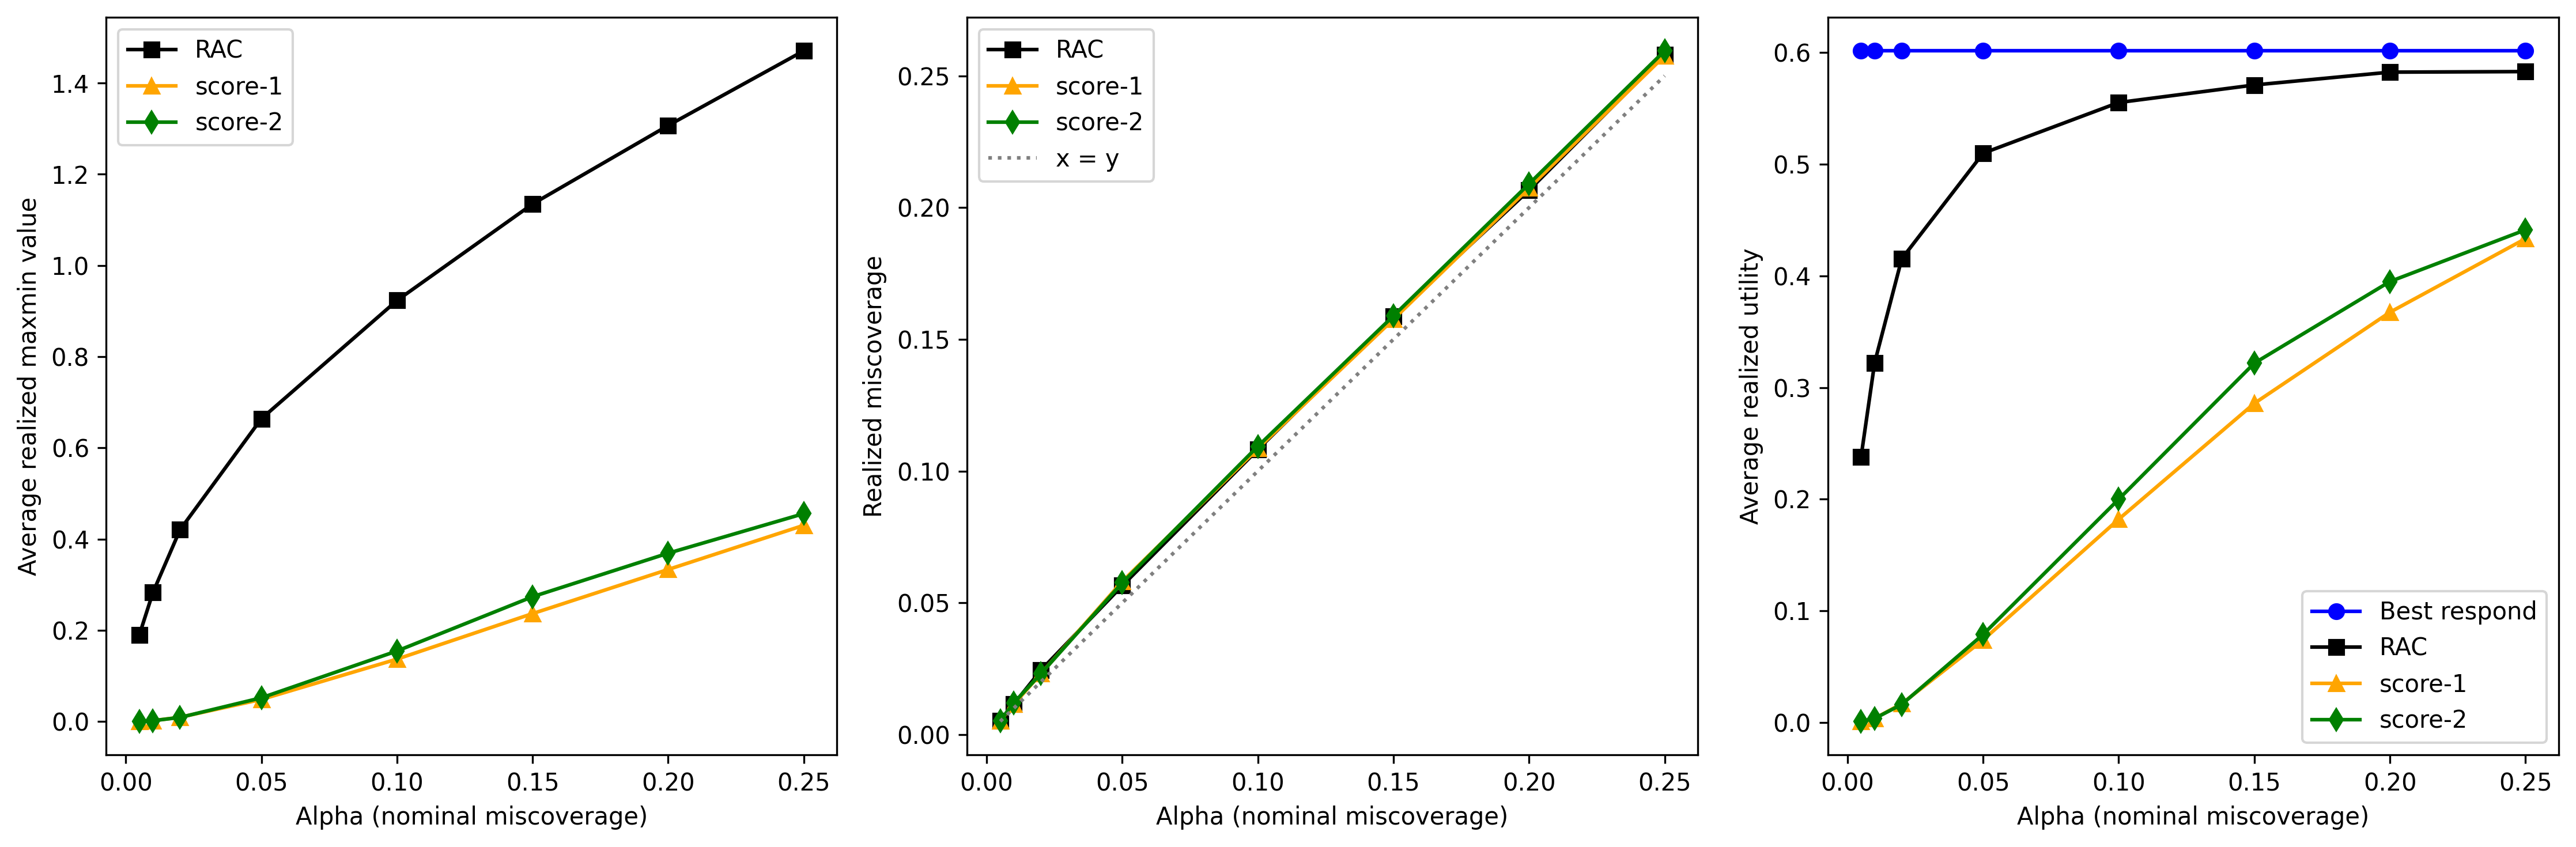

In [63]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

# Example values (you can replace these with your actual data)

alpha_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25]
# Define consistent colors
colors = {
    'ours': 'black',
    'b': 'blue',
    's1': 'orange',
    's2': 'green'
}


# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300, sharey=False)

# Plot 1: Averages
axes[2].plot(alpha_list, avg_b, label='Best respond', marker='o', color=colors['b'])
axes[2].plot(alpha_list, avg_ours, label='RAC', marker='s', color=colors['ours'])
axes[2].plot(alpha_list, avg_s1, label='score-1', marker='^', color=colors['s1'])
axes[2].plot(alpha_list, avg_s2, label='score-2', marker='d', color=colors['s2'])
axes[2].set_xlabel('Alpha (nominal miscoverage)')
axes[2].set_ylabel('Average realized utility')
axes[2].legend()
# axes[0].set_xticks(alpha_list)  # Set x-axis ticks to alpha_list

# Plot 2: Q-values
axes[1].plot(alpha_list, q_ours, label='RAC', marker='s', color=colors['ours'])
axes[1].plot(alpha_list, q_s1, label='score-1', marker='^', color=colors['s1'])
axes[1].plot(alpha_list, q_s2, label='score-2', marker='d', color=colors['s2'])

# Add x = y baseline as dotted line
axes[1].plot(alpha_list, alpha_list, label='x = y', linestyle=':', color='gray')

axes[1].set_xlabel('Alpha (nominal miscoverage)')
axes[1].set_ylabel('Realized miscoverage')
# axes[1].set_title('Plot of Q-values')
axes[1].legend()
# axes[1].set_xticks(alpha_list)  # Set x-axis ticks to alpha_list

# Plot 3: Maximums
axes[0].plot(alpha_list, max_ours, label='RAC', marker='s', color=colors['ours'])
axes[0].plot(alpha_list, max_s1, label='score-1', marker='^', color=colors['s1'])
axes[0].plot(alpha_list, max_s2, label='score-2', marker='d', color=colors['s2'])
axes[0].set_xlabel('Alpha (nominal miscoverage)')
axes[0].set_ylabel('Average realized maxmin value')
axes[0].legend()
# axes[2].set_xticks(alpha_list)  # Set x-axis ticks to alpha_list

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("icml_three_plots.pdf")
plt.show()


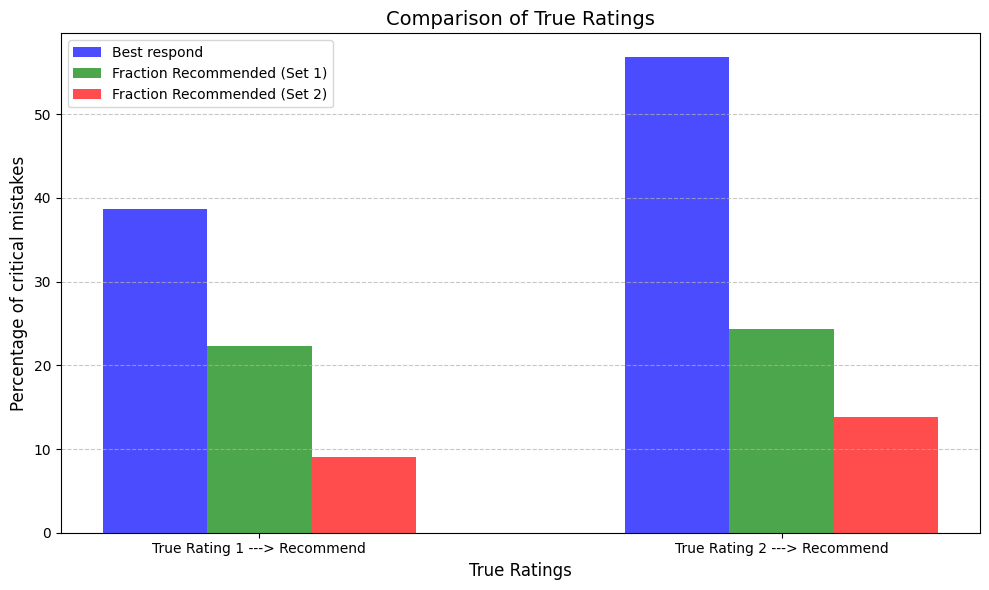

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Data for True Ratings
true_rating_labels = ["True Rating 1 ---> Recommend", "True Rating 2 ---> Recommend"]

# The following numbers are for the specific setup that is used for the paper.
#To reproduce this, or compute them for your own setup, you have to run the method of your interest with the specific value of alpha and then read the results and plug them in here.
#To run each of the methods, right after each method's implementaion in this file, there is an exmample, which helps you run the method.

true_rating_percent = [38.63, 56.83]
true_rating_fraction1 = [143/642 *100, 290/1193* 100]
true_rating_fraction2 = [58/642* 100, 165/1193* 100]



# Combine all data for plotting
bar_width = 0.2
x = np.arange(len(true_rating_labels))

plt.figure(figsize=(10, 6))

# Plot bars for Percentage
plt.bar(x - bar_width, true_rating_percent, width=bar_width, label='Best respond', color='blue', alpha=0.7)

# Plot bars for Fraction 1
plt.bar(x, true_rating_fraction1, width=bar_width, label='Fraction Recommended (Set 1)', color='green', alpha=0.7)

# Plot bars for Fraction 2
plt.bar(x + bar_width, true_rating_fraction2, width=bar_width, label='Fraction Recommended (Set 2)', color='red', alpha=0.7)

# Add labels and title
plt.xlabel('True Ratings', fontsize=12)
plt.ylabel('Percentage of critical mistakes', fontsize=12)
plt.title('Comparison of True Ratings', fontsize=14)
plt.xticks(ticks=x, labels=true_rating_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


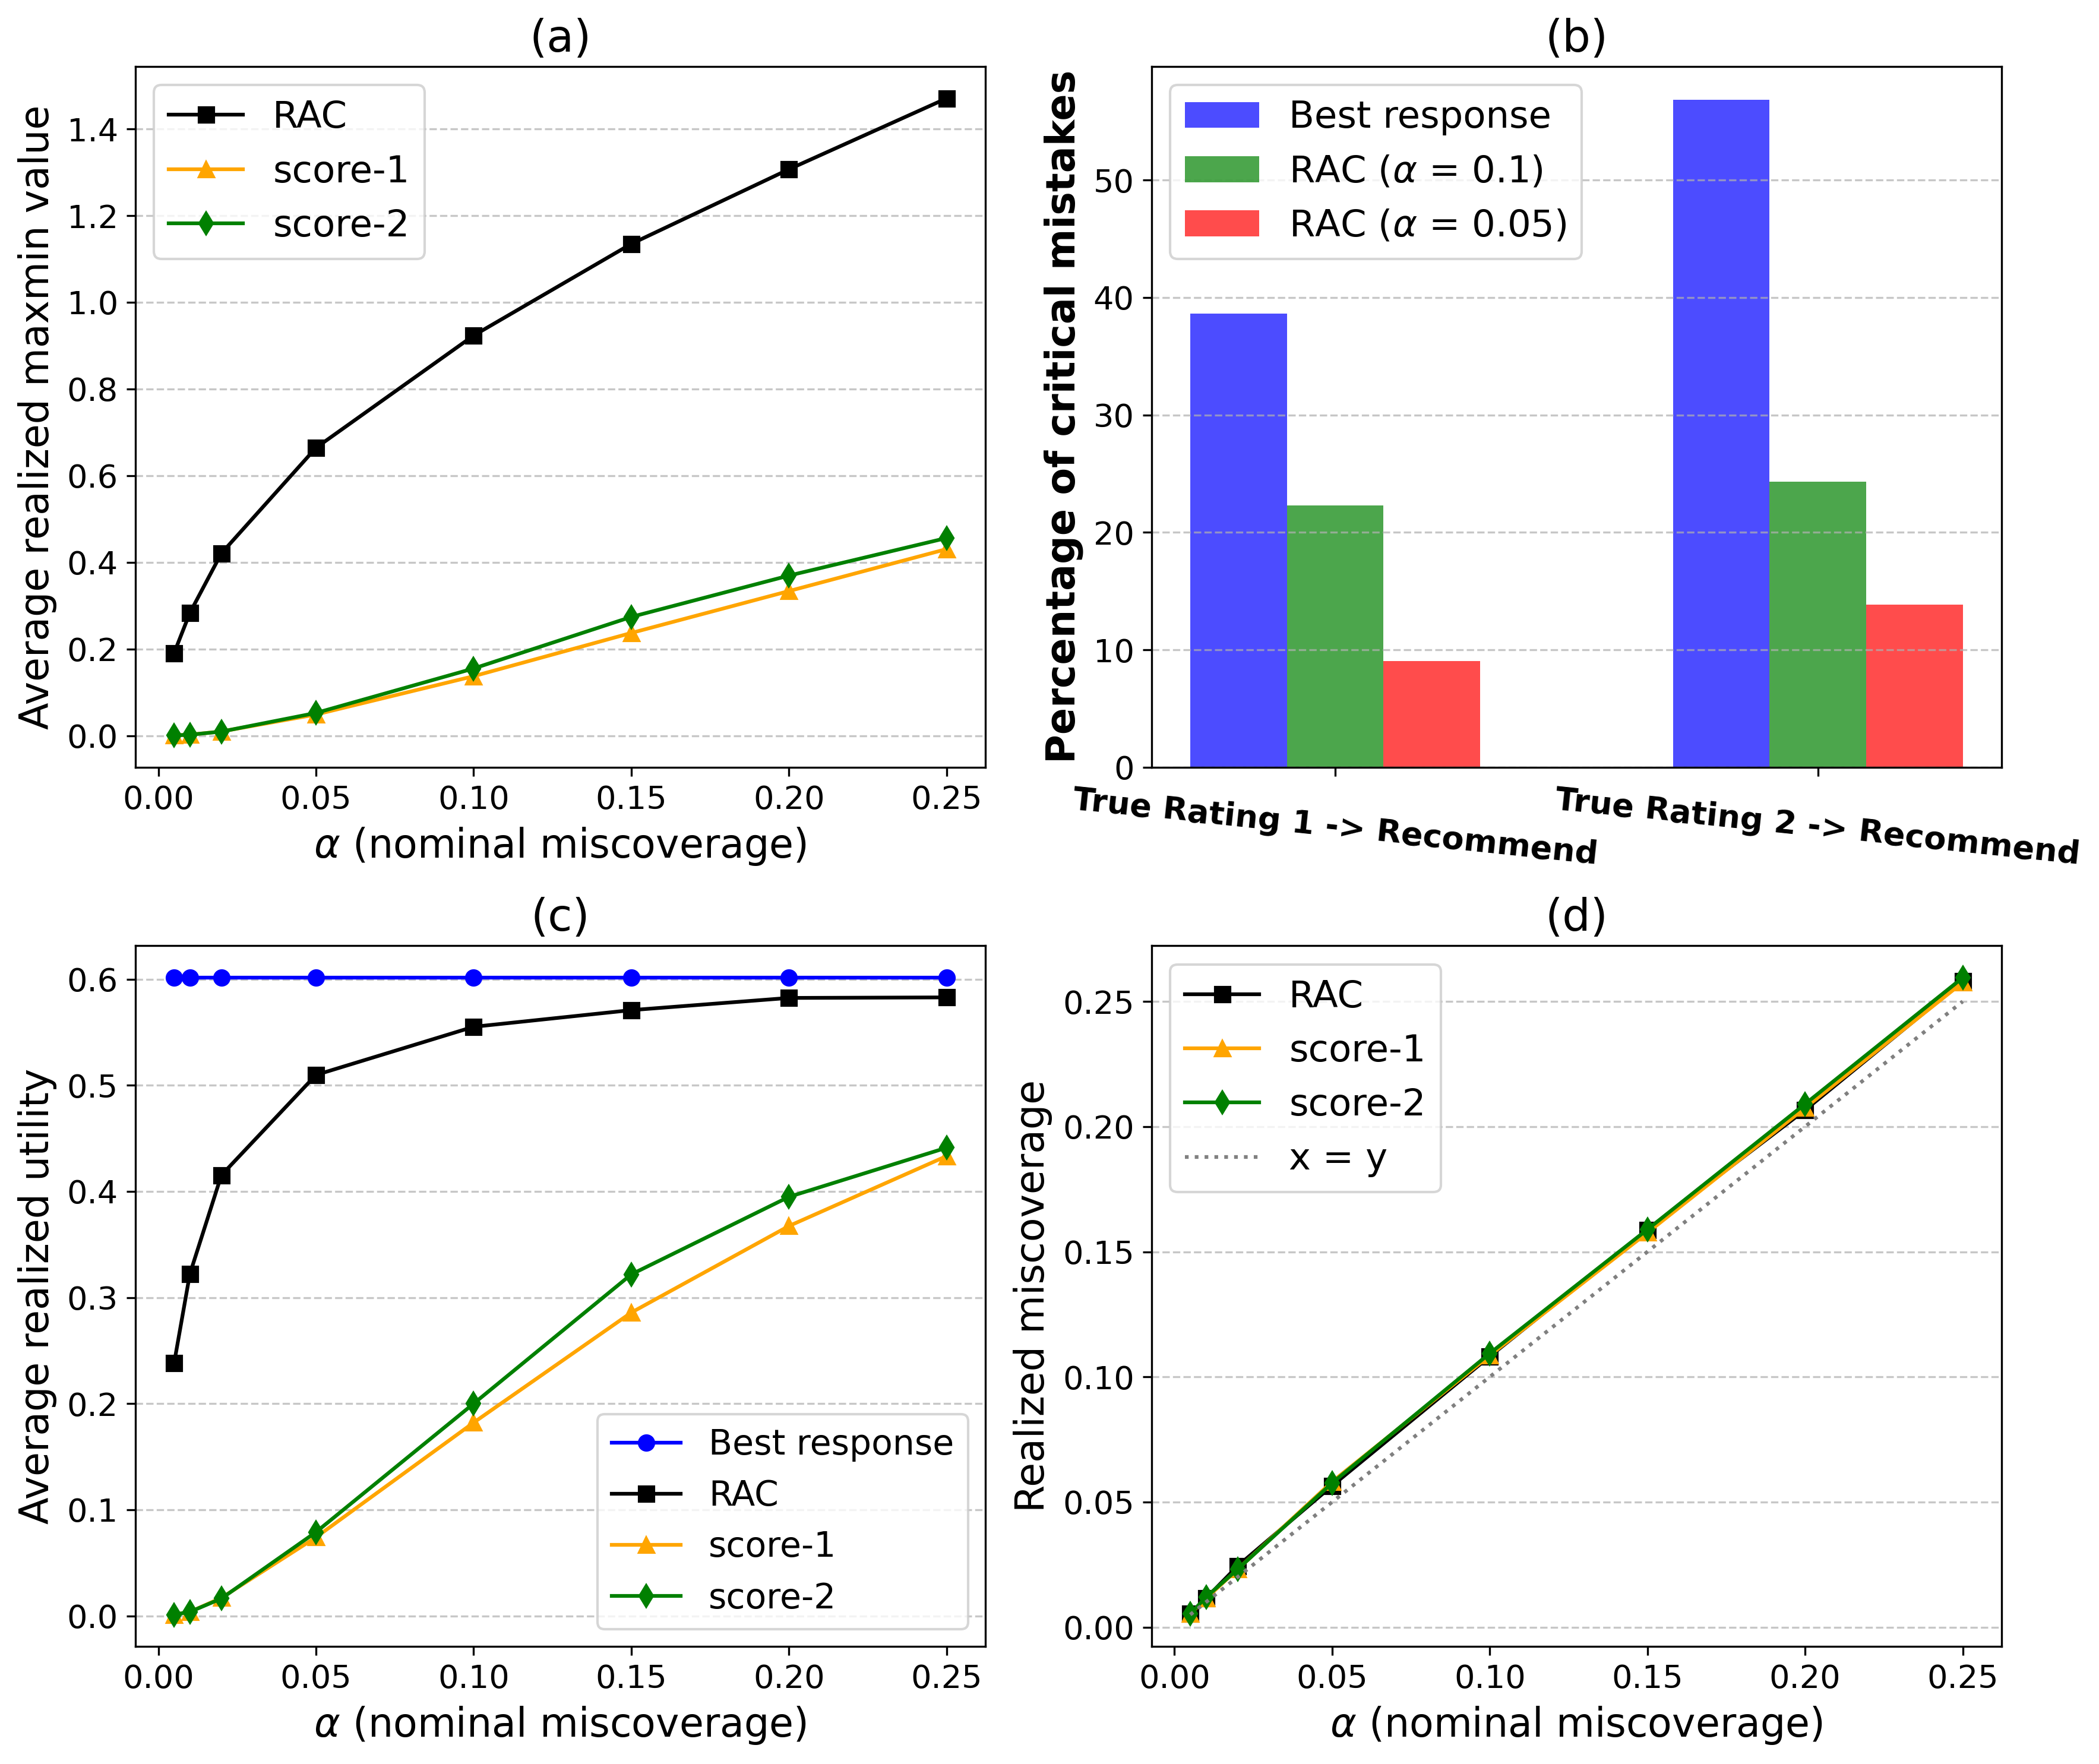

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Example values (you can replace these with your actual data)
alpha_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25]
# Define consistent colors
colors = {
    'ours': 'black',
    'b': 'blue',
    's1': 'orange',
    's2': 'green'
}

# The following numbers are for the specific setup that is used for the paper.
#To reproduce this, or compute them for your own setup, you have to run the method of your interest with the specific value of alpha and then read the results and plug them in here.
#To run each of the methods, right after each method's implementaion in this file, there is an exmample, which helps you run the method.



# Data for True Ratings
true_rating_labels = ["True Rating 1 -> Recommend", "True Rating 2 -> Recommend"]
true_rating_percent = [38.63, 56.83]
true_rating_fraction1 = [143/642 * 100, 290/1193 * 100]
true_rating_fraction2 = [58/642 * 100, 165/1193 * 100]

# Combine all data for plotting
bar_width = 0.2
x = np.arange(len(true_rating_labels))

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=300)

# Plot 1: Maximums
axes[0, 0].plot(alpha_list, max_ours, label='RAC', marker='s', color=colors['ours'])
axes[0, 0].plot(alpha_list, max_s1, label='score-1', marker='^', color=colors['s1'])
axes[0, 0].plot(alpha_list, max_s2, label='score-2', marker='d', color=colors['s2'])
axes[0, 0].set_xlabel(r'$\alpha$ (nominal miscoverage)', fontsize = 16)
axes[0, 0].set_ylabel('Average realized maxmin value', fontsize = 16)
axes[0, 0].legend(fontsize = 15)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0, 0].set_title('(a)', fontsize=18)

# Plot 2: Q-values
axes[1, 1].plot(alpha_list, q_ours, label='RAC', marker='s', color=colors['ours'])
axes[1, 1].plot(alpha_list, q_s1, label='score-1', marker='^', color=colors['s1'])
axes[1, 1].plot(alpha_list, q_s2, label='score-2', marker='d', color=colors['s2'])
axes[1, 1].plot(alpha_list, alpha_list, label='x = y', linestyle=':', color='gray')
axes[1, 1].set_xlabel(r'$\alpha$ (nominal miscoverage)', fontsize = 16)
axes[1, 1].set_ylabel('Realized miscoverage', fontsize = 16)
axes[1, 1].legend(fontsize = 15)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1, 1].set_title('(d)', fontsize=18)

# Plot 3: Averages
axes[1, 0].plot(alpha_list, avg_b, label='Best response', marker='o', color=colors['b'])
axes[1, 0].plot(alpha_list, avg_ours, label='RAC', marker='s', color=colors['ours'])
axes[1, 0].plot(alpha_list, avg_s1, label='score-1', marker='^', color=colors['s1'])
axes[1, 0].plot(alpha_list, avg_s2, label='score-2', marker='d', color=colors['s2'])
axes[1, 0].set_xlabel(r'$\alpha$ (nominal miscoverage)', fontsize = 16)
axes[1, 0].set_ylabel('Average realized utility', fontsize = 16)
axes[1, 0].legend(fontsize = 14)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
axes[1, 0].set_title('(c)', fontsize=18)

# Plot 4: True Ratings Comparison
axes[0, 1].bar(x - bar_width, true_rating_percent, width=bar_width, label='Best response', color='blue', alpha=0.7)
axes[0, 1].bar(x, true_rating_fraction1, width=bar_width, label=r'RAC ($\alpha$ = 0.1)', color='green', alpha=0.7)
axes[0, 1].bar(x + bar_width, true_rating_fraction2, width=bar_width, label=r'RAC ($\alpha$ = 0.05)', color='red', alpha=0.7)
axes[0, 1].set_title('(b)', fontsize=18)
axes[0, 1].set_ylabel('Percentage of critical mistakes', fontsize=16, fontweight='bold')
axes[0, 1].set_xticks(ticks=x)
axes[0, 1].set_xticklabels(true_rating_labels, fontsize= 12, fontweight='bold', rotation = -6)
axes[0, 1].legend(fontsize = 15)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=13)  # Increase font size of both x and y ticks
# axes[0, 1].set_xticklabels(true_rating_labels, fontsize= 11, fontweight='bold', rotation = -4)

# Adjust layout
plt.tight_layout()
plt.savefig("icml_2x2_plots_movie.pdf")
plt.show()
